<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/vgg_vs_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Preprocessing** 

In [8]:
## for preprocessing
import pandas as pd
import os
import shutil
import math 
import numpy as np
import random 

## For plotting
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
from IPython.display import Image
from google.colab.patches import cv2_imshow
import cv2
%matplotlib inline


## For machine learning
import keras
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential, Model 
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers import Dropout, Activation, Flatten, GlobalAveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
###### PNG --> NUMPY CONVERSION of FER2013

#get file paths for training and test images
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

#initialize lists to save data
train_data = []
train_label = []
test_data = []
test_label = []

#y label encoding in a dictionary
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

def unison_shuffled_copies(a, b):
    '''Shuffles two arrays in sync using permutations.'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  '''Converts png images into numpy arrays with their labels and stores them in a shuffled array.

  Input:
  folder_path - Path to folder where images for each emotion are stored in a different folder
  label_dict - Dictionary of labels and their encodings   

  Output:
  data -  Array of image arrays
  label - Array of image labels 
  '''

  data = []
  label = []
  for category in os.listdir(folder_path): 
    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)

  data = np.array(data)
  label = np.array(label)
  data, label = unison_shuffled_copies(data, label)
  return data, label

#get test and training data in numpy array format from png files
train_data, train_label = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label = get_image_arrays(test_path, emotion_dictionary)

#save test and training set for future use 
np.savez('/content/drive/MyDrive/Capstone/datasets/train.npz',train_data, train_label)
np.savez('/content/drive/MyDrive/Capstone/datasets/test.npz',test_data, test_label)

**1. Imitating RGB** 

FER2013 photos are grayscale, whereas both ResNet50 and VGG16 require a 3-channel RGB input to the neural network architecture. In order to emulate this, we can layer the grayscale with two additional channels that are duplicates of the original grayscale channel. Since the image will be the same overall three channels, the performance of the neural network should be the same as it was on RGB images.



Text(0.5, 0.98, 'Figure 1. Visualizing Random Images from the FER2013 Dataset')

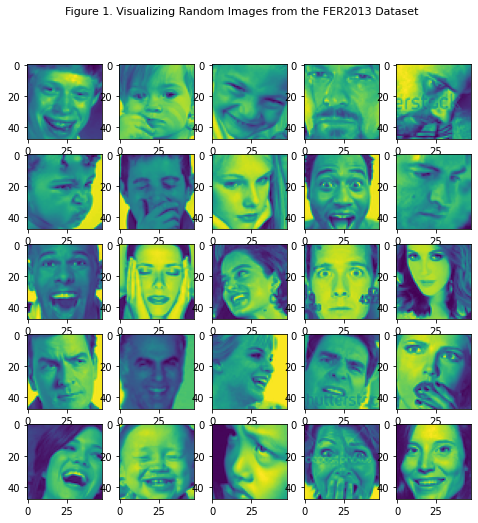

In [3]:
###### LOAD DATA FROM DRIVE 
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

#visualize random samples
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[random.randint(0,len(x_train))])

fig.suptitle('Figure 1. Visualizing Random Images from the FER2013 Dataset', fontsize=11)

Text(0.5, 1.0, 'Figure 2. Emotion Class Distribution in Training Data')

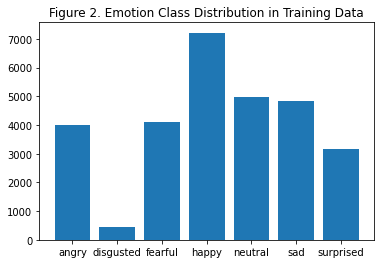

In [4]:
###### CLASS DISTRIBUTION

#visualize class distribution
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts = np.unique(y_train, return_counts=True)
class_dist = {} #true class distribution
for i in range(len(values)):
  class_dist[i] = counts[i]

plt.bar(emotion_dictionary.keys(),class_dist.values())
plt.title("Figure 2. Emotion Class Distribution in Training Data")

<BarContainer object of 7 artists>

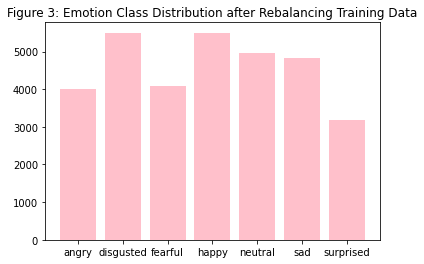

In [5]:
###### FIX CLASS IMBALANCE 

#randomly undersample majority class 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class  using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize resampled class distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Figure 3: Emotion Class Distribution after Rebalancing Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

In [6]:
###### PREPARE DATASET FOR

# both VGG and ResNet require RGB images but FER2013 is grayscale 
#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.2)

#resize to make sure input is the correct shape
x_train = np.resize(x_train, (len(x_train), 48,48,3))
x_val = np.resize(x_val, (len(x_val), 48,48,3))
x_test = np.resize(x_test, (len(x_test), 48,48,3))

print("Sizes of dataset after splitting into train, test, and validation set:")
print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)

Sizes of dataset after splitting into train, test, and validation set:
Train --  (32058, 48, 48, 3) (32058,)
Val --  (5742, 48, 48, 3) (5742,)
Test --  (1436, 48, 48, 3) (1436,)


**3. Data Augmentation** 

I performed data augmentation using sklearn's ImageGenerator method in order to deal with overfitting. I used the following steps to augment data. 


In [7]:
###### DATA AUGMENTATION

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=bs)
    
epochs = 30
bs = 256

train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
val_path = '/content/drive/MyDrive/Capstone/FER2013/val/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_generator  = get_datagen(train_path, True)
val_generator    = get_datagen(val_path)
test_generator  = get_datagen(test_path)

Found 28709 images belonging to 7 classes.
Found 6069 images belonging to 7 classes.
Found 1109 images belonging to 7 classes.


## ResNet50


In [15]:
#Load Pretrained ResNet50 Model 
input_tensor = K.Input(shape=(48,48,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_tensor)

#Freezing Layers 
n_freeze = 165
for layer in res50_model.layers[:n_freeze]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (n_freeze - 3):  
    print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
163 conv5_block2_add - False
164 conv5_block2_out - False
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2_conv - True
169 conv5_block3_2_bn - True
170 conv5_block3_2_relu - True
171 conv5_block3_3_conv - True
172 conv5_block3_3_bn - True
173 conv5_block3_add - True
174 conv5_block3_out - True


In [16]:

## Build the model
model=K.models.Sequential()
model.add(res50_model) #pre-trained model with frozen layers 

# stacking more layers 

model.add(K.layers.Flatten())
model.add(K.layers.Dropout(0.5))
#model.add(K.layers.BatchNormalization())

model.add(K.layers.Dense(4096,kernel_initializer='he_uniform'))
#model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(1024,kernel_initializer='he_uniform'))
#model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(7,activation='softmax'))


## Compile Model 
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=.0001, nesterov=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 activation (Activation)     (None, 4096)              0         
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)             

In [ ]:
#create path to checkpoint to save model weights
ckpt_path = os.path.join('/content/drive/MyDrive/Capstone/datasets', 'ckpt_res50') 
#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#reduce learning rate when performance doesn't increase for 5 epochs
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 5,verbose = 1,factor = 0.1, min_lr = 1e-10)
#stop early if performance doesn't increase substantially for 10 epochs
es = EarlyStopping(min_delta=0, verbose=1, patience=15)


#Train the model using min--batch gradient descent
history = model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[lrd, es, check_point])

model.save(ckpt_path)

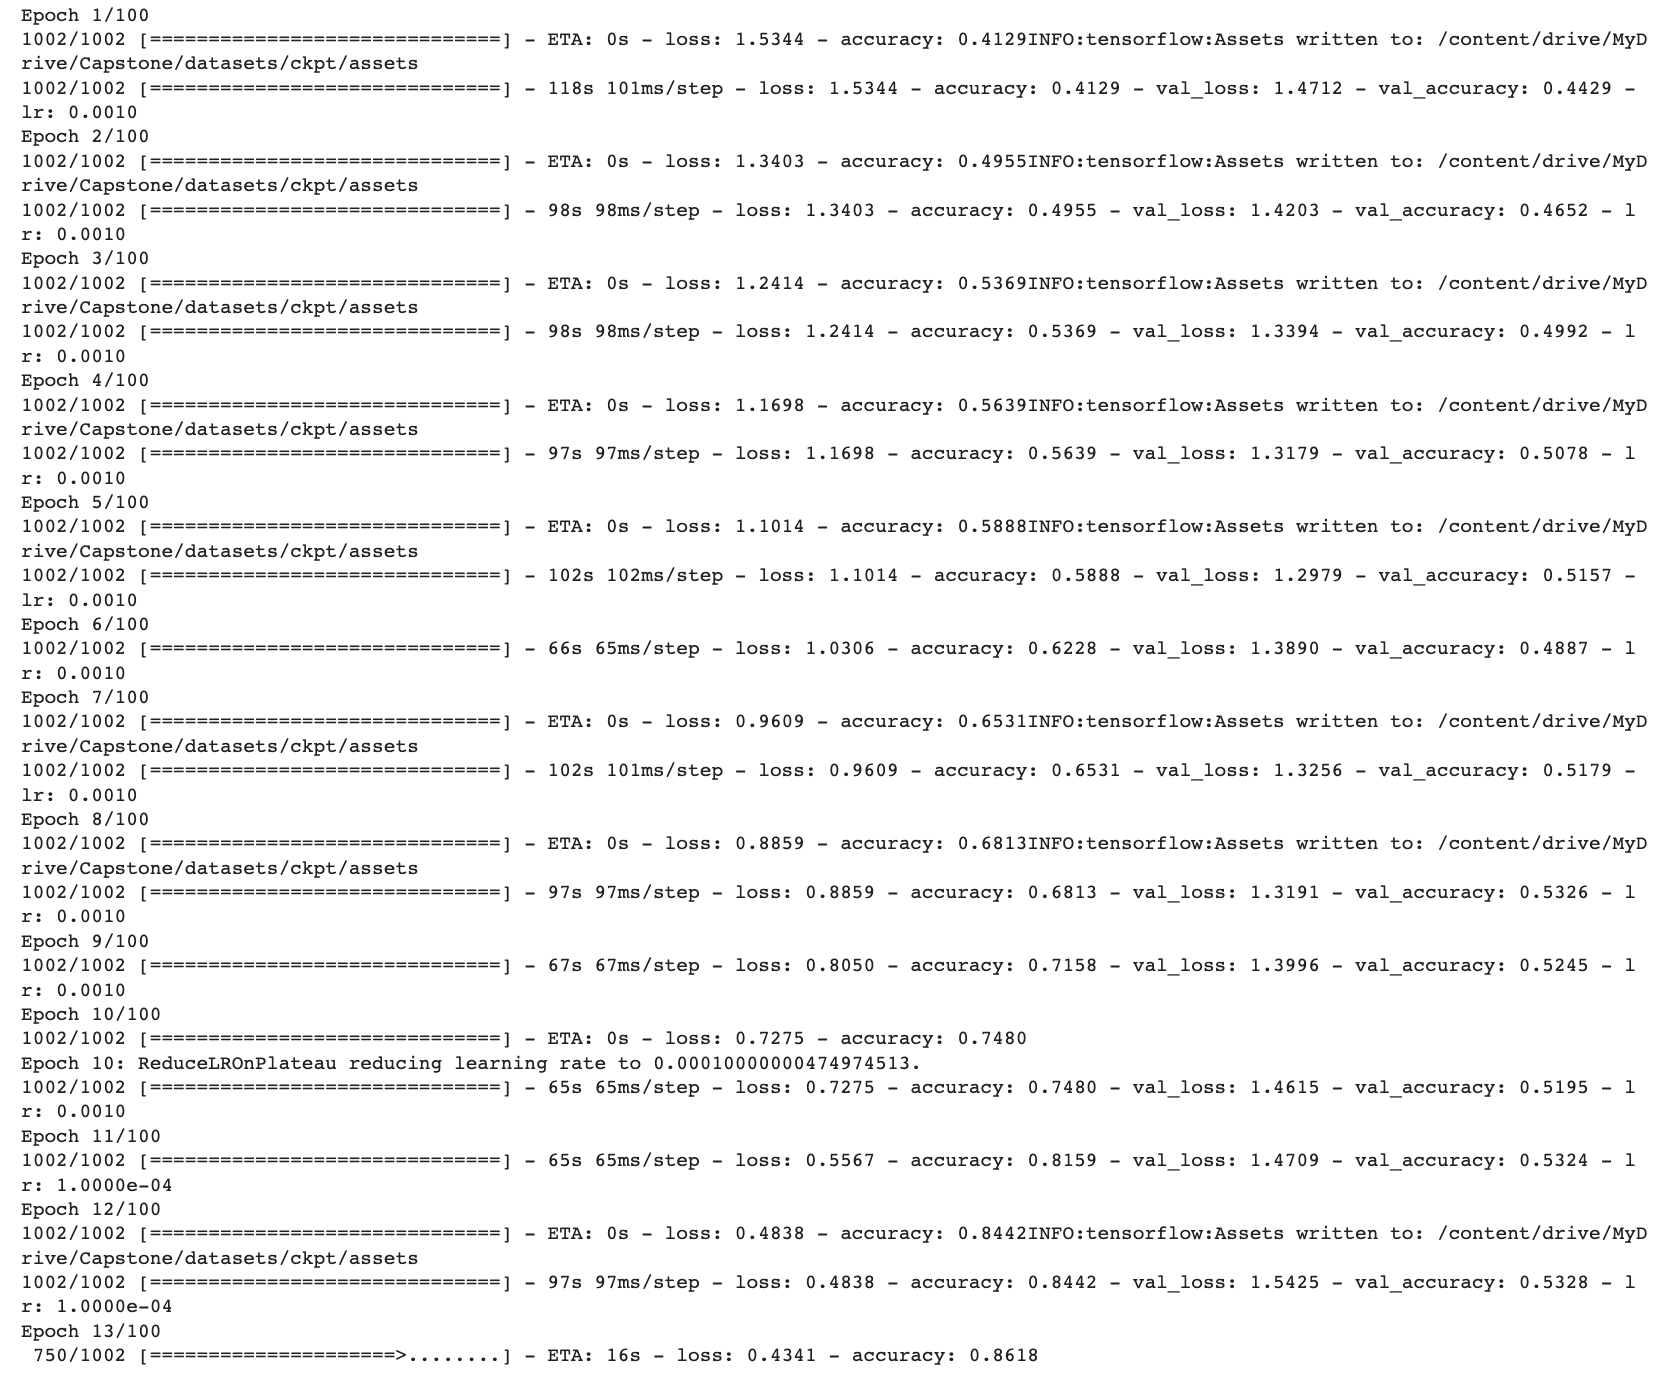

In [41]:
img = cv2.imread('/content/drive/MyDrive/screens/d.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
hist = history.history
train_acc = hist['accuracy']
train_loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

plt.title("Model Loss for Training and Validation Set")
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

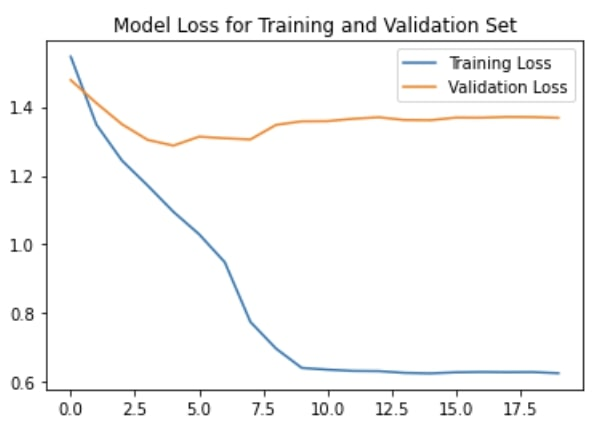

In [37]:

img = cv2.imread('/content/drive/MyDrive/screens/_.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
plt.title("Model Accuracy for Training and Validation Set")
plt.plot(train_acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend()


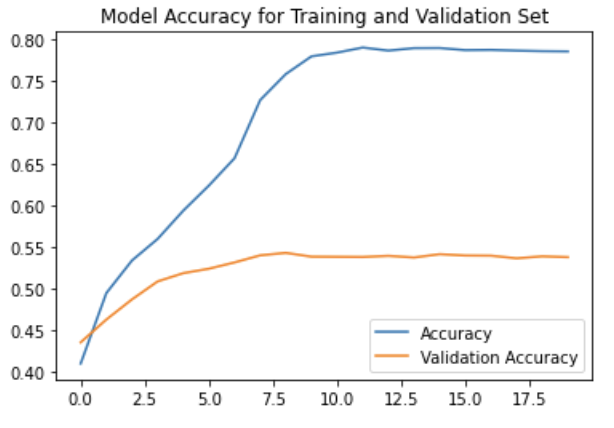

In [39]:
img = cv2.imread('/content/drive/MyDrive/screens/b.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
###### TESTING 
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

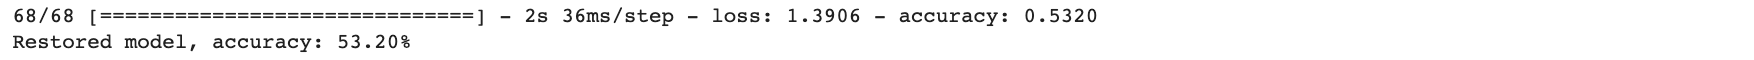

In [40]:
img = cv2.imread('/content/drive/MyDrive/screens/c.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

## VGG16

In [9]:
vgg = VGG16(weights = 'imagenet', include_top=False, input_shape= (48,48,3))
n_freeze = 19
for layer in vgg.layers[:n_freeze]:
  layer.trainable=False

for (i,layer) in enumerate(vgg.layers):
  print(str(i)+' '+ layer.__class__.__name__, layer.trainable)

def fully_connected(base_model, num_classes):
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  return x

num_class = 7
FC_head = fully_connected(vgg, num_class)
model = Model(inputs=vgg.input, outputs = FC_head)
print(model.summary())

rms_lr = 0.001
sgd_lr = 0.01
adam_lr = 0.001
sgd_decay = 0.0001

sgd = SGD(learning_rate=sgd_lr, momentum=0.9, decay=sgd_decay, nesterov=True) 
adam = Adam(learning_rate=adam_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
rms = RMSprop(learning_rate=rms_lr)

model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                               

In [ ]:
lrd = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
checkpoint = ModelCheckpoint('face_vgg.h5', monitor = 'val_accuracy', mode ='max', save_best_only = True, verbose=1)
callbacks = [checkpoint, es, lrd]

history = model.fit(train_generator, #x_train, y_train,  
                    epochs=epochs, 
                    verbose=1,
                    validation_data= val_generator, #(x_val, y_val),
                    max_queue_size=100,
                    workers = 10 ,# (set a proper value > 1)
                    use_multiprocessing=True,
                    callbacks=callbacks)

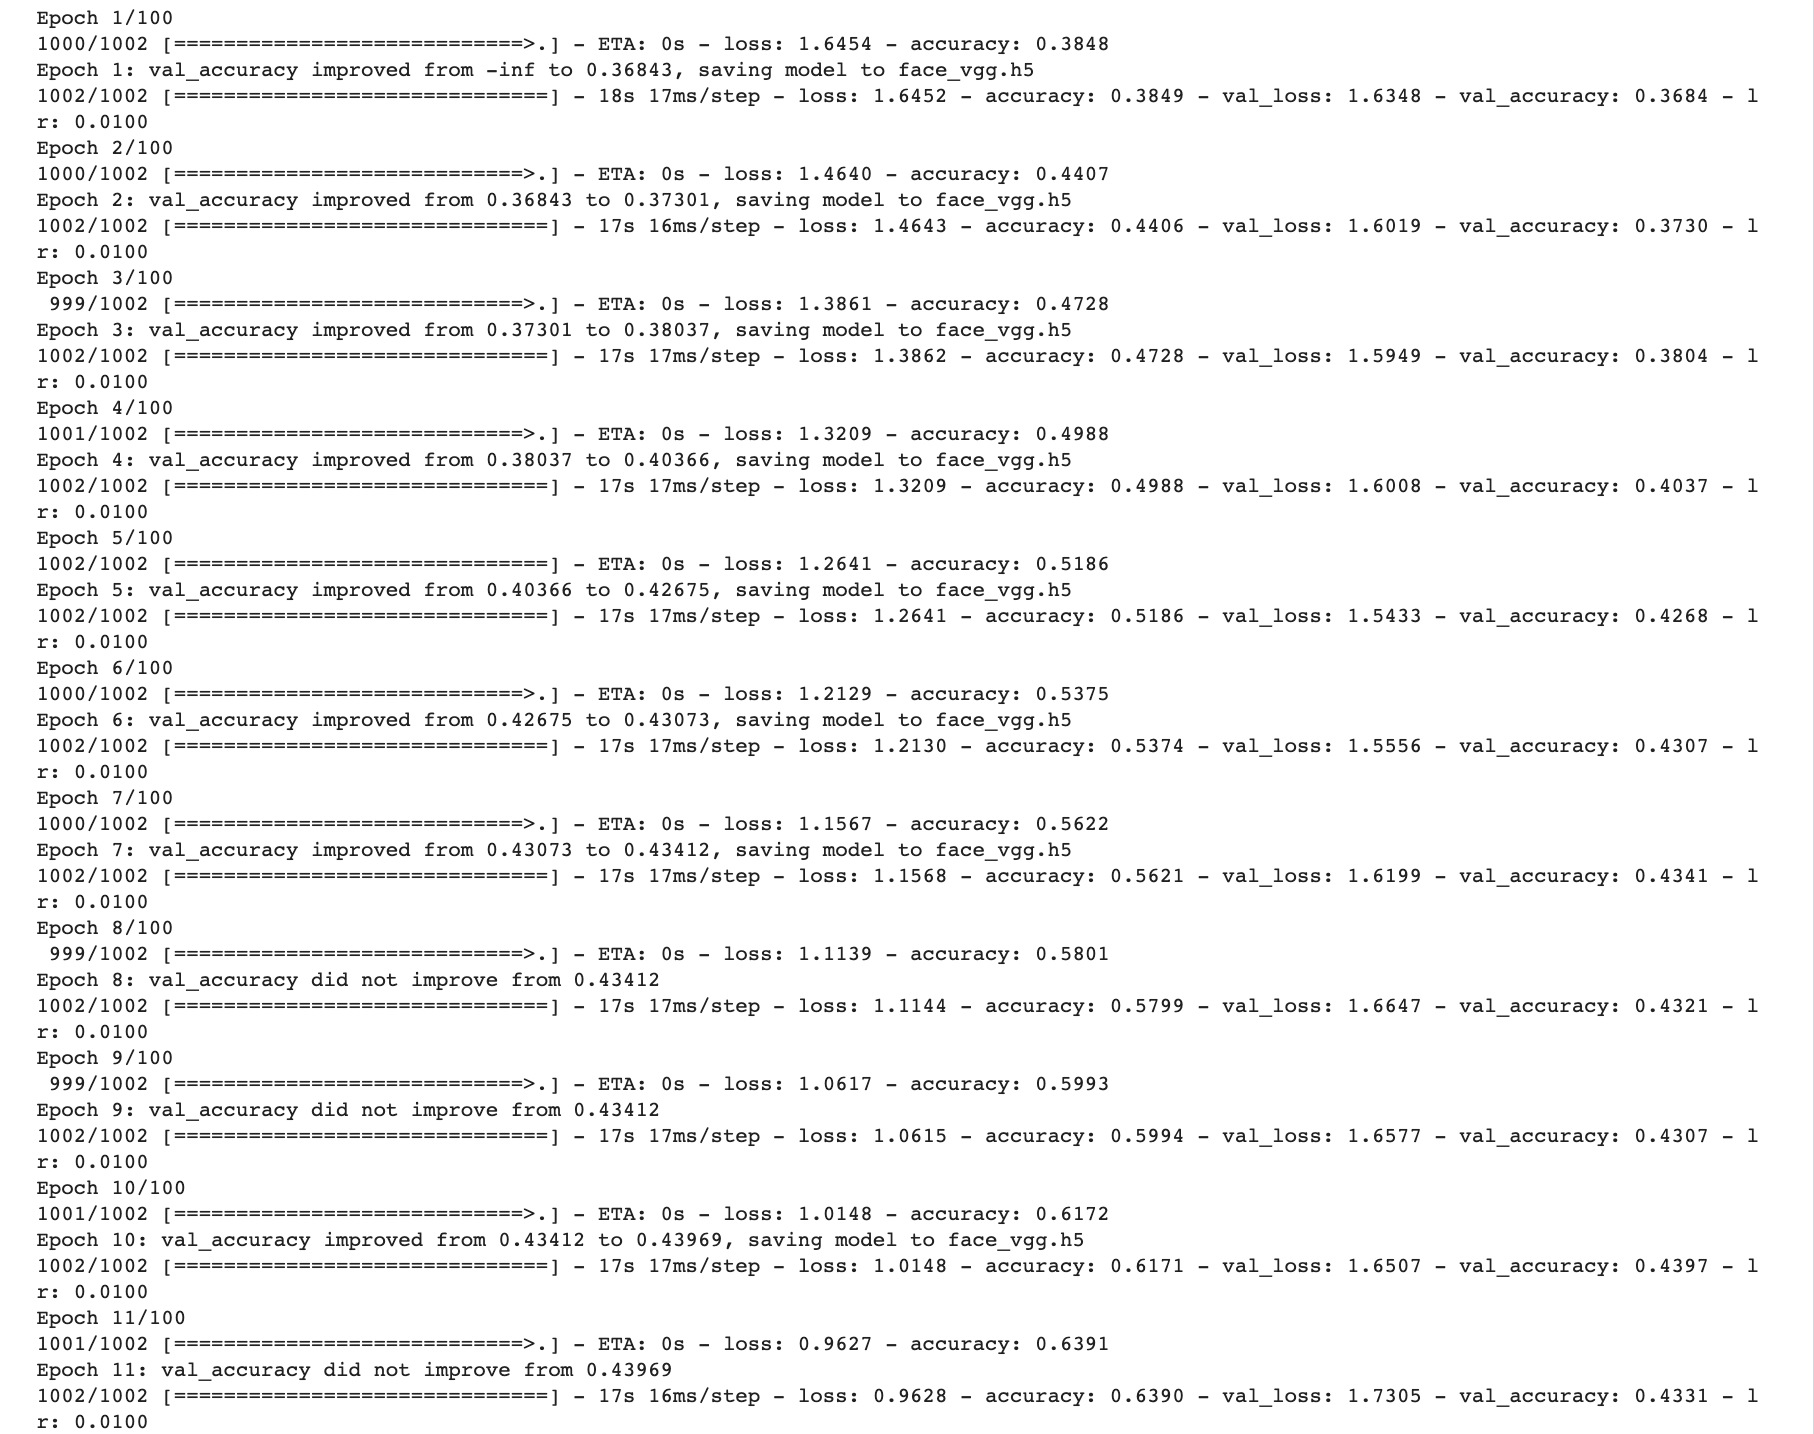

In [9]:
img = cv2.imread('/content/drive/MyDrive/screens/e.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

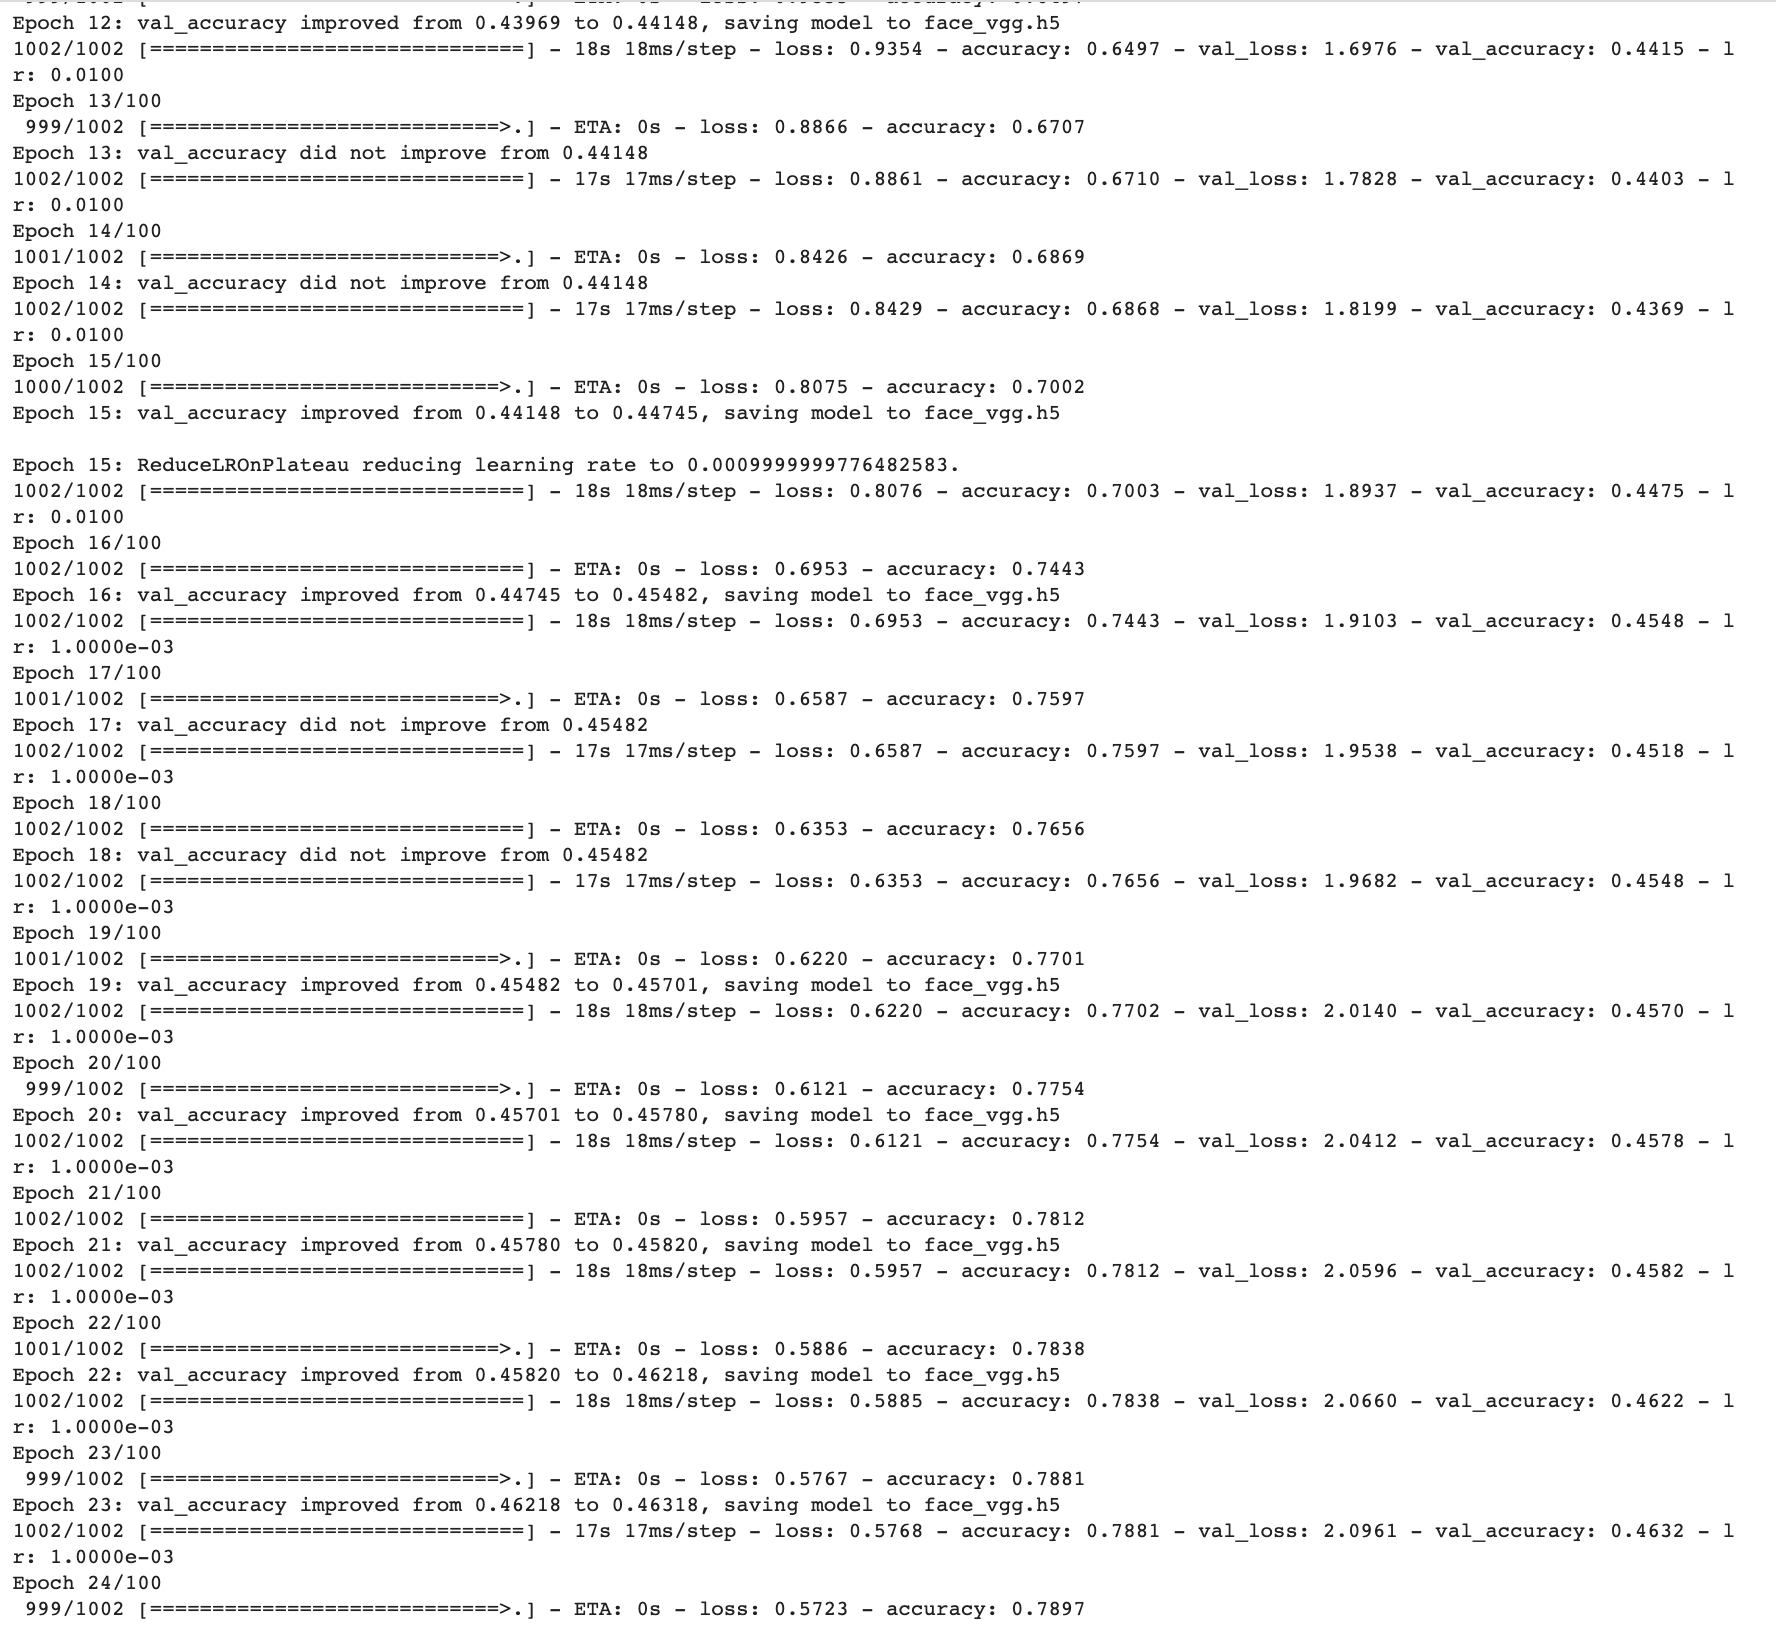

In [10]:
img = cv2.imread('/content/drive/MyDrive/screens/f.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

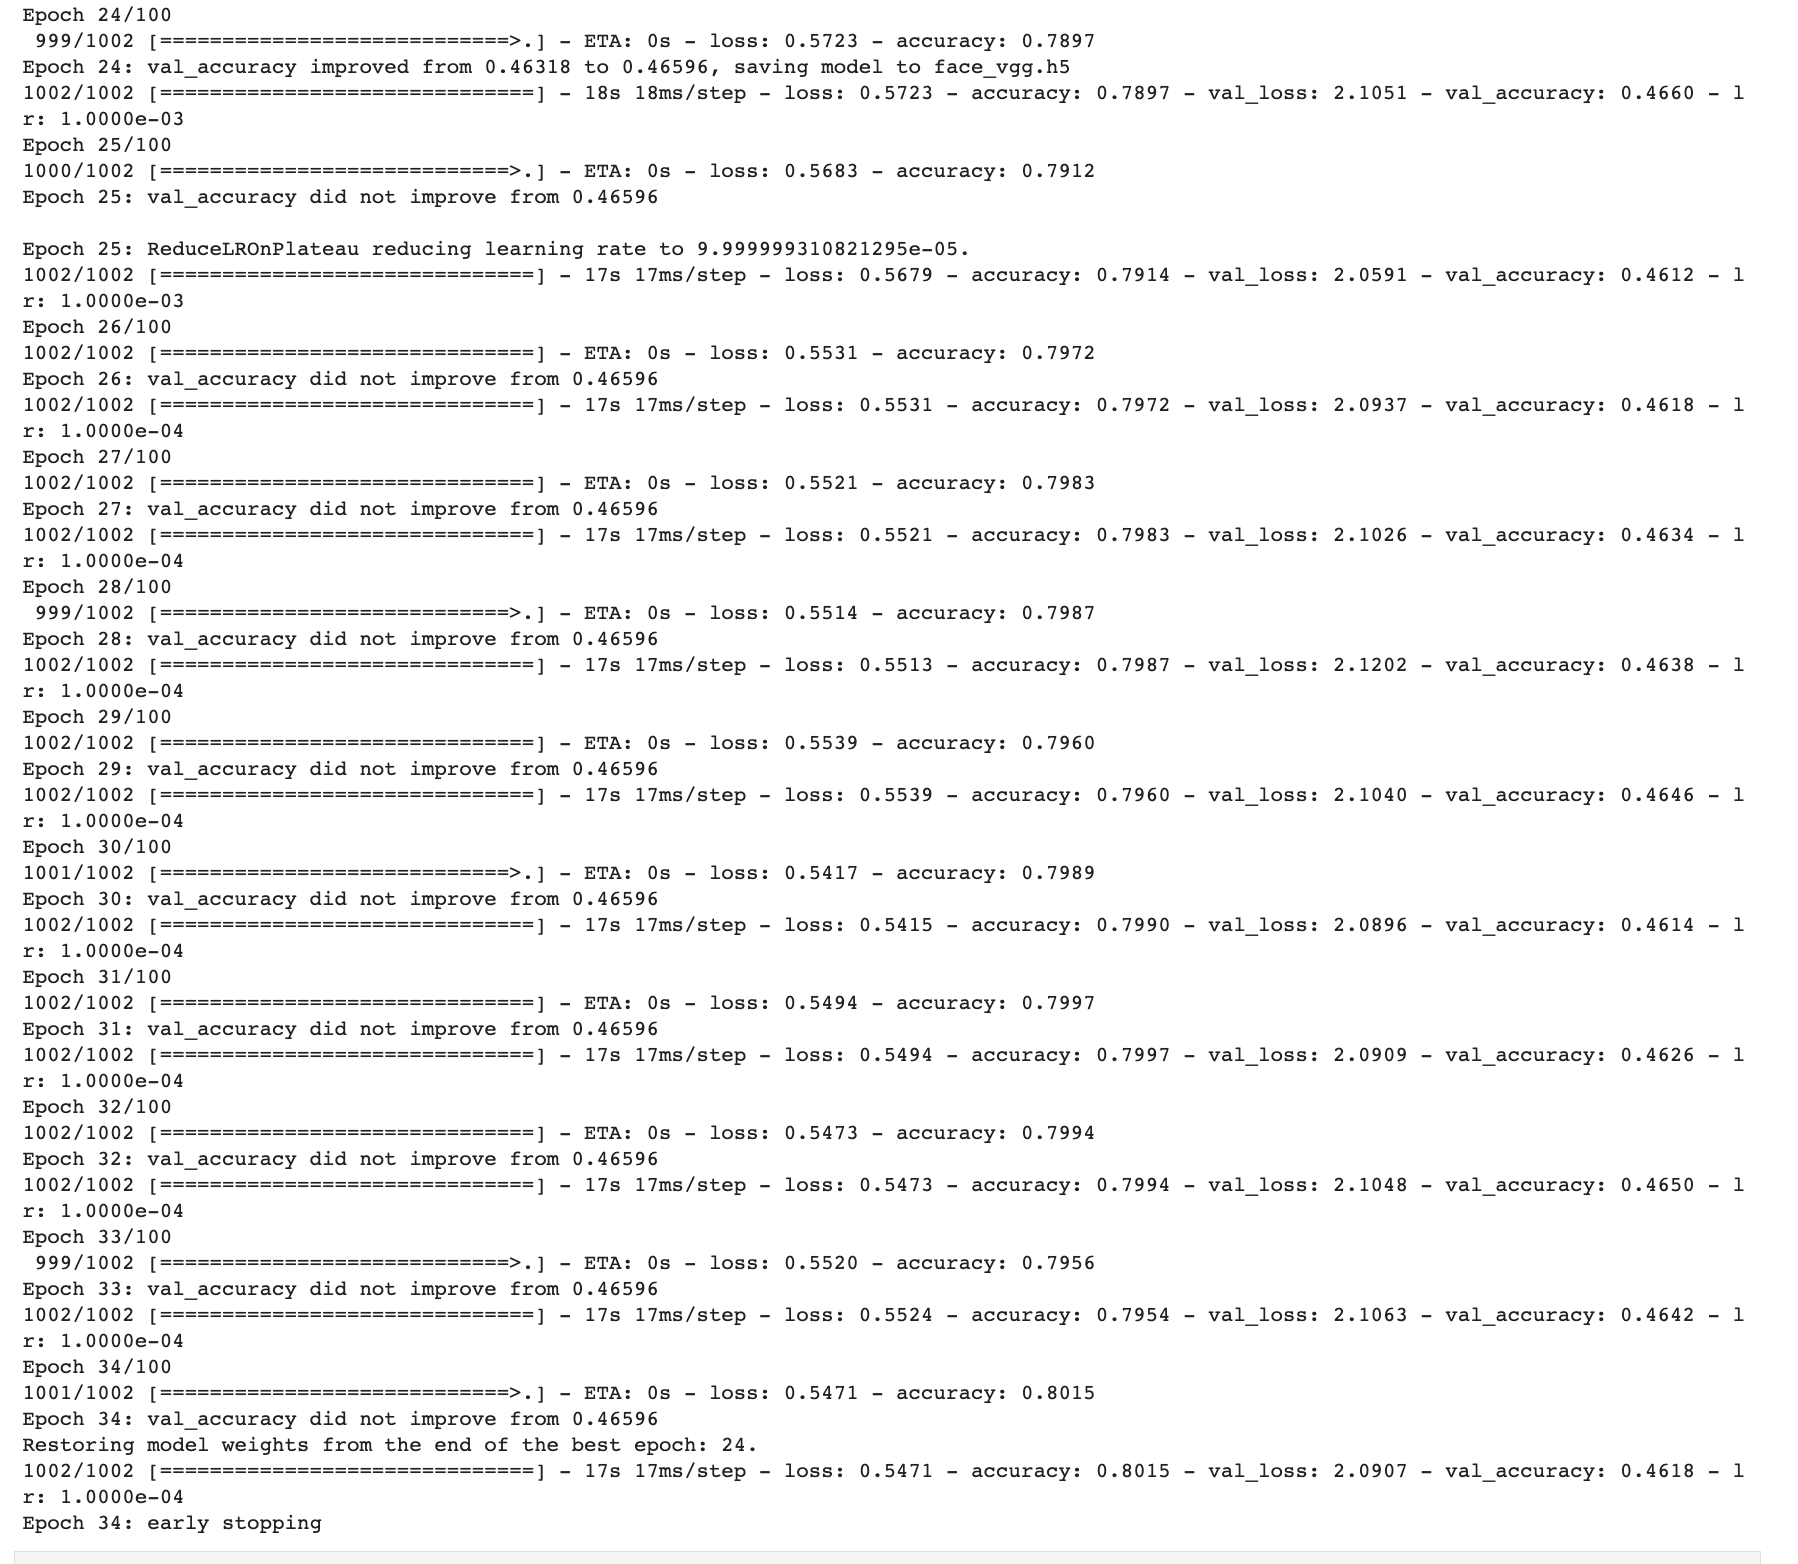

In [11]:
img = cv2.imread('/content/drive/MyDrive/screens/g.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

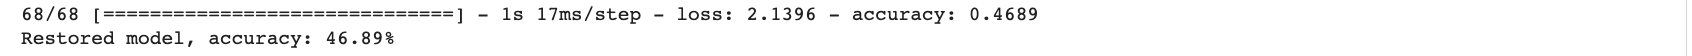

In [13]:
img = cv2.imread('/content/drive/MyDrive/screens/h.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)